# Quantum Random Walk on a Quantum Computer

Differently from a Classical Random Walk, in a Quantum Random Walk, particles move in superposition, navigating multiple paths simultaneously. Due to quantum interference the resulting final distribution is very diffuse and exhibits unique patterns that can lead to both constructive and destructive interference. This property holds promise for applications in quantum algorithms, optimization, and simulating complex systems.

### Classical -> Quantum walk
Assuming you have **seen already and went through "Classical Random Walk.ipynb"** you know how to use a quantum computer to simulate classical random walks. 

No more ingredients are needed. In order to simulate a quantum walk one needs only to make use of the accumulated results of each coin flip. This means that only one qubit is needed for the coin, which will be repeatedly flipped at each step using an 'H' gate. Well, an 'H' gate, followed by an 'S' gate, since the accumulated phase would otherwise cause the system to [drift towards the left](https://quantumai.google/cirq/experiments/quantum_walks). 

Let's first import all the functions that we have defined in the previous notebook.


In [1]:
from numpy import pi
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit import Aer, execute
from qiskit.circuit.library import QFT


def encode_basis(n, double=False):
    num_qubits = n.bit_length()
    
    if double:
        num_qubits *= 2
        num_qubits -= 1
        
    qnum = QuantumRegister(num_qubits, 'q_num')
    
    circuit = QuantumCircuit(qnum)
    
    for i in range(num_qubits):
        if (n >> i) & 1:
            circuit.x(qnum[i])
    return circuit

def qcoin(bias=0.5):
    if bias < 0 or bias > 1:
        raise ValueError("Bias should be between 0 and 1")
    
    qcoin_reg = QuantumRegister(1)
    qc = QuantumCircuit(qcoin_reg)
    qc.h(0)   
    theta = pi * (1 - 2 * bias)   
    qc.ry(theta, 0)
    return qc

def add_qft_gate(n):
    add = QuantumCircuit(n, name='add_qft')
    for q in range(n-1):
        add.cp(pi/(2**q),n-1,q)
    add.x(n-1)
    return add.to_instruction()


def sub_qft_gate(n):
    add = QuantumCircuit(n, name='sub_qft')
    for q in range(n-1):
        add.cp(-pi/(2**q),n-1,q)
    add.x(n-1)
    return add.to_instruction()


def decode_result(result):
    return {int(k, 2):result[k] for k in result.keys()}


def cat_qc(*all_qc):
    out_qc_qregs =[]
    out_qc_cregs =[]    
    for qc in all_qc:
        out_qc_qregs += qc.qregs
        out_qc_cregs += qc.cregs
    out_qc = QuantumCircuit(*out_qc_qregs, *out_qc_cregs)

    qubits_offset = 0
    clbits_offset = 0

    for qc in all_qc:
        out_qc.compose(qc,
                       [i for i in range(qubits_offset,qubits_offset+qc.num_qubits)],
                       [i for i in range(clbits_offset,clbits_offset+qc.num_clbits)],
                       inplace=True)
        qubits_offset += qc.num_qubits    
        clbits_offset += qc.num_clbits    

    return out_qc

### Run the quantum walk and plot results

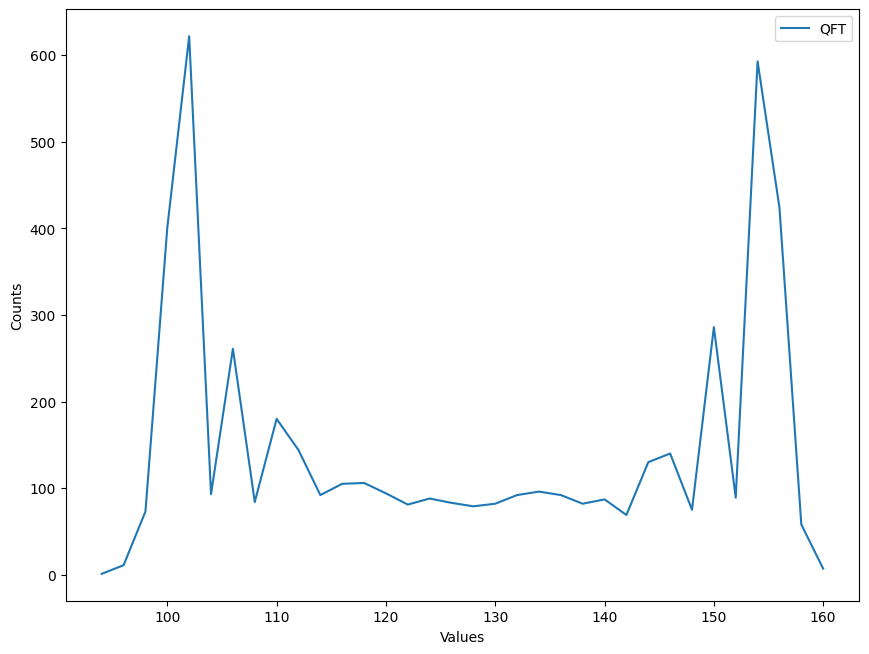

In [2]:
single_qcoin_reg = QuantumRegister(1, 'single_q_coin')
single_qcoin = QuantumCircuit(single_qcoin_reg)
single_qcoin.h(0)
single_qcoin.s(0)

n = 2**7
qnum = encode_basis(n,double=False)
add = add_qft_gate(qnum.num_qubits+1)
sub = sub_qft_gate(qnum.num_qubits+1)

steps = 40
num_coins = steps

qc = cat_qc(qnum,single_qcoin)

qc.append(QFT(qnum.num_qubits, do_swaps=False, inverse=False), range(qnum.num_qubits))
for i in range(steps):
    qc.append(add,range(qc.num_qubits))
    qc.append(sub,range(qc.num_qubits))
    qc.h(qc.num_qubits-1)
qc.append(QFT(qnum.num_qubits, do_swaps=False, inverse=True), range(qnum.num_qubits))

qc.add_register(ClassicalRegister(qnum.num_qubits+1))
qc.measure([i for i in range(qnum.num_qubits)],[i for i in range(qnum.num_qubits)])
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=5000)
result = job.result().get_counts(qc)
result = decode_result(result)

plt.ion()
fig, ax = plt.subplots(figsize = (10.24,7.68))

x = sorted(result.keys())
y = [result[k] for k in x]
ax.plot(x, y, label='QFT')

plt.legend()
plt.xlabel('Values')
plt.ylabel('Counts')
plt.show()
plt.ioff()

### Compare Classical and Quantum Random Walk results

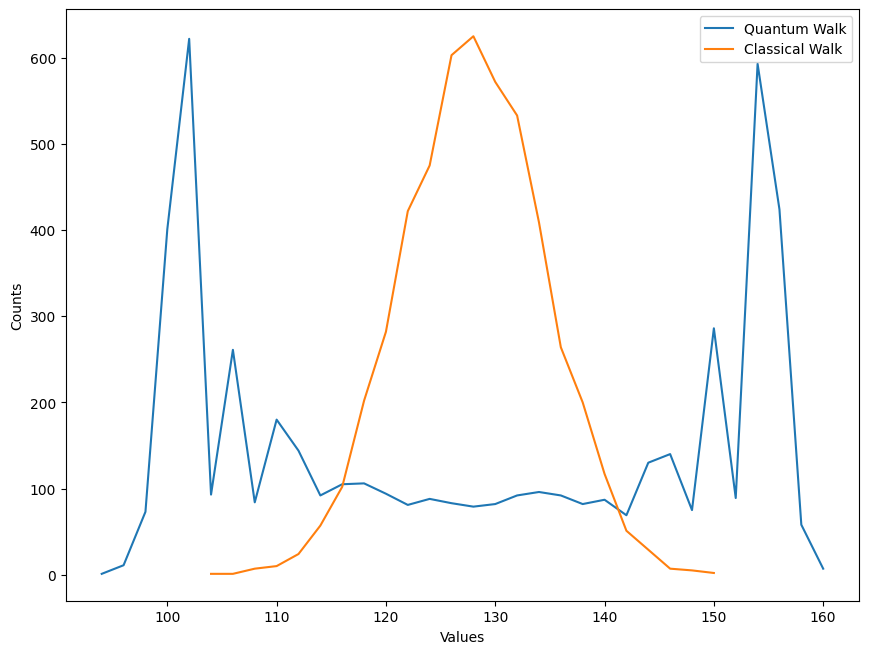

In [3]:
n = 2**7
qnum = encode_basis(n,double=False)
steps = 40
num_coins = steps

qc_qft = cat_qc(qnum,*[qcoin() for _ in range(num_coins)])

add_qft = add_qft_gate(qnum.num_qubits+1)
sub_qft = sub_qft_gate(qnum.num_qubits+1)

qc_qft.append(QFT(qnum.num_qubits, do_swaps=False, inverse=False), range(qnum.num_qubits))
for i in range(steps):
    qc_qft.append(add_qft,[*(range(qnum.num_qubits)), qc_qft.num_qubits-1-i])
    qc_qft.append(sub_qft,[*(range(qnum.num_qubits)), qc_qft.num_qubits-1-i])   
qc_qft.append(QFT(qnum.num_qubits, do_swaps=False, inverse=True), range(qnum.num_qubits))

qc_qft.add_register(ClassicalRegister(qnum.num_qubits+1))
qc_qft.measure([i for i in range(qnum.num_qubits)],[i for i in range(qnum.num_qubits)])
backend = Aer.get_backend('qasm_simulator')
job_qft = execute(qc_qft, backend, shots=5000)
result_qft = job_qft.result().get_counts(qc_qft)
result_qft = decode_result(result_qft)

plt.ion()
fig, ax = plt.subplots(figsize = (10.24,7.68))

x_qft = sorted(result_qft.keys())
y_qft = [result_qft[k] for k in x_qft]
ax.plot(x, y, label='Quantum Walk')
ax.plot(x_qft, y_qft, label='Classical Walk')

plt.legend()
plt.xlabel('Values')
plt.ylabel('Counts')
plt.show()
plt.ioff()